In [1]:
import requests

import pandas as pd
import matplotlib.pyplot as plt

from Historic_Crypto import HistoricalData

# Fear and Greed Index API

Free API that provides one index per day.

`'time_until_update'` value - present only for the last output 

* API just for Bitcoin

 **What this index includes?**
* Volatility = 25%
* Market Momentum/Volume = 25%
* Social Media (twitter & reddit) = 15%
* Surveys (currently posed) = 15%
* Dominance (based on Bitcoin) = 10%
* Trends = 10%

In [3]:
url = 'https://api.alternative.me/fng/'
params = {'limit': 100000,
          'date_format': 'world'
         }
response = requests.get(url, params).json()
response

{'name': 'Fear and Greed Index',
 'data': [{'value': '52',
   'value_classification': 'Neutral',
   'timestamp': '24-01-2023',
   'time_until_update': '-1674501115'},
  {'value': '50',
   'value_classification': 'Neutral',
   'timestamp': '23-01-2023'},
  {'value': '53',
   'value_classification': 'Neutral',
   'timestamp': '22-01-2023'},
  {'value': '53',
   'value_classification': 'Neutral',
   'timestamp': '21-01-2023'},
  {'value': '51',
   'value_classification': 'Neutral',
   'timestamp': '20-01-2023'},
  {'value': '45', 'value_classification': 'Fear', 'timestamp': '19-01-2023'},
  {'value': '52',
   'value_classification': 'Neutral',
   'timestamp': '18-01-2023'},
  {'value': '51',
   'value_classification': 'Neutral',
   'timestamp': '17-01-2023'},
  {'value': '45', 'value_classification': 'Fear', 'timestamp': '16-01-2023'},
  {'value': '52',
   'value_classification': 'Neutral',
   'timestamp': '15-01-2023'},
  {'value': '46', 'value_classification': 'Fear', 'timestamp': '14-0

In [4]:
fng_df = pd.DataFrame(response['data']).drop(columns='time_until_update')
fng_df

,value,value_classification,timestamp
0,52,Neutral,24-01-2023
1,50,Neutral,23-01-2023
2,53,Neutral,22-01-2023
3,53,Neutral,21-01-2023
4,51,Neutral,20-01-2023
...,...,...,...
1811,11,Extreme Fear,05-02-2018
1812,24,Extreme Fear,04-02-2018
1813,40,Fear,03-02-2018
1814,15,Extreme Fear,02-02-2018


In [5]:
fng_df.timestamp = pd.to_datetime(fng_df.timestamp, format='%d-%m-%Y')
fng_df.set_index('timestamp', inplace=True)

In [6]:
fng_df.value = fng_df.value.astype('float')

In [7]:
fng_df.head()

,value,value_classification
timestamp,,
2023-01-24,52.0,Neutral
2023-01-23,50.0,Neutral
2023-01-22,53.0,Neutral
2023-01-21,53.0,Neutral
2023-01-20,51.0,Neutral


In [8]:
fng_df.dtypes

value                   float64
value_classification     object
dtype: object

In [17]:
min_val = fng_df[fng_df.value == fng_df.value.min()]
min_val

,value,value_classification
timestamp,,
2019-08-22,5.0,Extreme Fear


In [19]:
max_val = fng_df[fng_df.value == fng_df.value.max()]
max_val

,value,value_classification
timestamp,,
2021-02-17,95.0,Extreme Greed
2021-02-16,95.0,Extreme Greed
2021-02-14,95.0,Extreme Greed
2021-02-09,95.0,Extreme Greed
2021-01-06,95.0,Extreme Greed
2020-12-31,95.0,Extreme Greed
2020-12-18,95.0,Extreme Greed
2020-12-14,95.0,Extreme Greed
2020-12-08,95.0,Extreme Greed


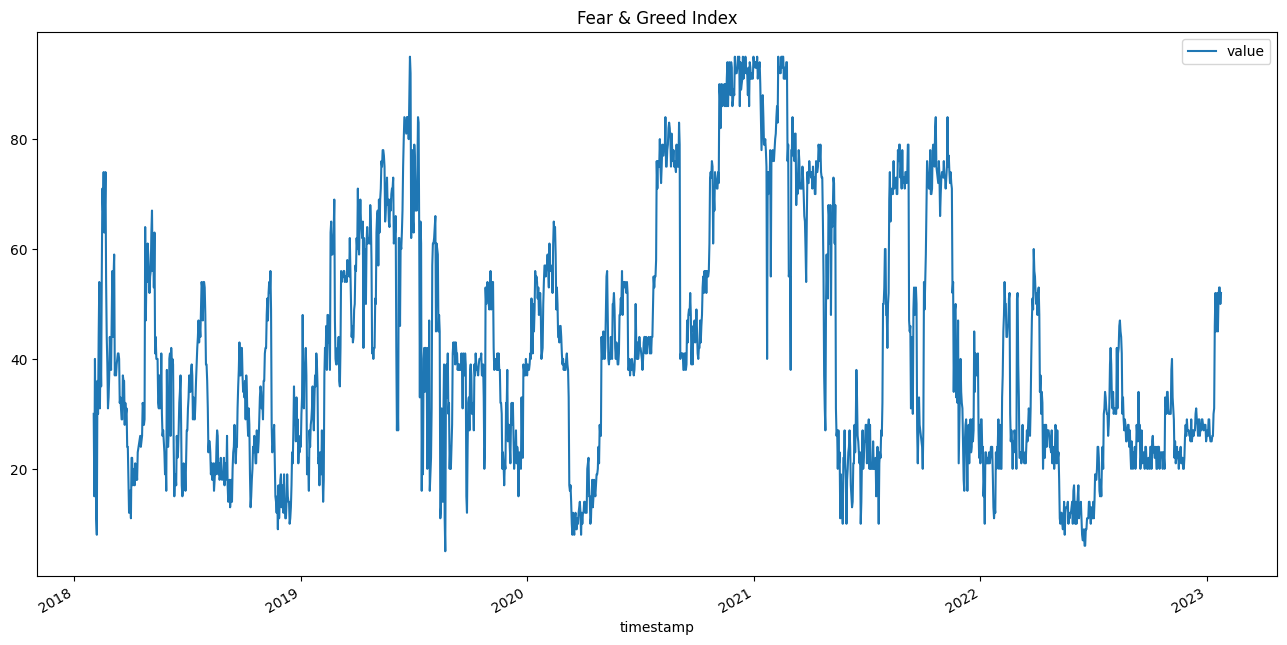

In [20]:
fng_df.plot(y='value', use_index=True, figsize=(16,8), title='Fear & Greed Index');

# Historical data

Library that provides historical crypto data

In [33]:
dataset = HistoricalData(start_date = '2023-01-01-05-05',
                        ticker = 'BTC-USDT',
                        granularity=86400,
                        verbose = False).retrieve_data()
dataset

,low,high,open,close,volume
time,,,,,
2023-01-02,16550.47,16793.73,16621.31,16674.64,560.136545
2023-01-03,16607.28,16776.17,16669.91,16675.13,877.292216
2023-01-04,16653.48,16989.00,16676.28,16851.55,1537.125774
2023-01-05,16755.98,16878.57,16854.64,16832.64,677.574942
2023-01-06,16683.57,17034.18,16830.47,16954.37,734.480835
2023-01-07,16908.82,16980.23,16954.37,16947.07,156.980319
2023-01-08,16912.14,17173.99,16949.22,17129.39,373.843563
2023-01-09,17106.66,17396.00,17130.95,17179.43,1148.278780
2023-01-10,17146.91,17492.64,17180.20,17442.12,940.418862


In [ ]:
API_KEY = COIN_API

params ={
    
    
}

url = 'https://rest.coinapi.io/v1/exchangerate/BTC/USD/history?period_id=1DAY&time_start=2018-02-01T00:00:00&time_end=2022-12-02T00:00:00&limit=100000'
headers = {'X-CoinAPI-Key' : 'A100C8DD-420E-48A3-B17D-000AC6D20B7F'} #API-key
response = requests.get(url, headers=headers).json()
response